<a href="https://colab.research.google.com/github/nthammadi-uncc/MultiEffects_AirPollutants/blob/main/Notebooks/Multi_Effects_Model_for_Electricity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-effects Model of Sustainable and Non-Sustainable Electricity Usage and its impact on Carbon Emissions across the US

#### Install libraries

In [1]:
#run both R and python 
%load_ext rpy2.ipython

##### Install packages

In [2]:
#mount google drive to load pre installs and zipped libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#extract library zip file from location - https://drive.google.com/drive/folders/1z3tM37Cf7zr3hXF5EtPMRnMwdoEb6arm
%cp drive/MyDrive/R_libraries/library.tar.gz .

In [4]:
!du -sh library.tar.gz

494M	library.tar.gz


In [5]:
#copy library to current directory
!tar xf library.tar.gz

tar: Removing leading `/' from member names


In [6]:
%ls usr/local/lib/R/site-library/

abind/           emmeans/       htmlwidgets/  pbdZMQ/         shinythemes/
arrayhelpers/    estimability/  httpuv/       plyr/           sourcetools/
bayesplot/       fontawesome/   igraph/       polyclip/       StanHeaders/
BH/              furrr/         inline/       posterior/      svUnit/
bridgesampling/  future/        IRdisplay/    promises/       tensorA/
brms/            ggdag/         IRkernel/     RColorBrewer/   threejs/
Brobdingnag/     ggdist/        later/        Rcpp/           tidybayes/
broom/           ggforce/       lazyeval/     RcppArmadillo/  tidygraph/
broom.mixed/     ggh4x/         listenv/      RcppEigen/      tweenr/
checkmate/       ggokabeito/    loo/          RcppParallel/   V8/
cmdstanr/        ggraph/        markdown/     repr/           viridis/
coda/            ggrepel/       matrixStats/  reshape2/       xtable/
colourpicker/    ggridges/      miniUI/       rstan/          xts/
crosstalk/       globals/       mvtnorm/      rstantools/     zoo/
dagitt

In [7]:
%%R
.libPaths('usr/local/lib/R/site-library/')

In [8]:
%%R
.libPaths()

[1] "/content/usr/local/lib/R/site-library"
[2] "/usr/local/lib/R/site-library"        
[3] "/usr/lib/R/site-library"              
[4] "/usr/lib/R/library"                   


##### Load packages

In [9]:
%%R
library(readr)
library(dplyr)
library(tidyverse)
library(magrittr)

library(dagitty)
library(ggdag)
library(ggplot2)

library(brms)
library(tidybayes)
library(rstan)

library(broom)        # Convert model objects to data frames
library(broom.mixed)  # Convert brms model objects to data frames
library(emmeans)      # Calculate marginal effects in even fancier ways
library(ggh4x)        # For nested facets in ggplot
library(ggrepel)      # For nice non-overlapping labels in ggplot
library(ggdist)       # For distribution-related ggplot geoms
library(scales)       # For formatting numbers with comma(), dollar(), etc.
library(patchwork)    # For combining plots
library(ggokabeito)   # Colorblind-friendly color palette

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:purrr’:

    set_names


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: 
Attaching package: ‘ggdag’


R[write to console]: The following obj

In [10]:
#load font
!wget "https://fonts.google.com/download?family=Barlow%20Semi%20Condensed"
!unzip "download?family=Barlow Semi Condensed"
#!mv BarlowSemiCondensed-Regular.ttf /usr/share/fonts/truetype/

!fc-cache -f -v

--2022-04-11 21:11:38--  https://fonts.google.com/download?family=Barlow%20Semi%20Condensed
Resolving fonts.google.com (fonts.google.com)... 142.251.120.113, 142.251.120.139, 142.251.120.102, ...
Connecting to fonts.google.com (fonts.google.com)|142.251.120.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download?family=Barlow Semi Condensed’

download?family=Bar     [ <=>                ] 915.13K  --.-KB/s    in 0.05s   

2022-04-11 21:11:38 (16.9 MB/s) - ‘download?family=Barlow Semi Condensed’ saved [937092]

Archive:  download?family=Barlow Semi Condensed
  inflating: OFL.txt                 
  inflating: BarlowSemiCondensed-Thin.ttf  
  inflating: BarlowSemiCondensed-ThinItalic.ttf  
  inflating: BarlowSemiCondensed-ExtraLight.ttf  
  inflating: BarlowSemiCondensed-ExtraLightItalic.ttf  
  inflating: BarlowSemiCondensed-Light.ttf  
  inflating: BarlowSemiCondensed-LightItalic.ttf  
  inflating: BarlowSemiConden

In [11]:
%%R
# Custom ggplot theme to make pretty plots
# Get Barlow Semi Condensed at https://fonts.google.com/specimen/Barlow+Semi+Condensed
theme_clean <- function() {
  theme_minimal(base_family = "Barlow Semi Condensed") +
    theme(panel.grid.minor = element_blank(),
          plot.background = element_rect(fill = "white", color = NA),
          plot.title = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          strip.text = element_text(face = "bold", size = rel(0.8), hjust = 0),
          strip.background = element_rect(fill = "grey80", color = NA),
          legend.title = element_text(face = "bold"))
}

# Make labels use Barlow by default
update_geom_defaults("label_repel", 
                     list(family = "Barlow Semi Condensed",
                          fontface = "bold"))
update_geom_defaults("label", 
                     list(family = "Barlow Semi Condensed",
                          fontface = "bold"))

#### Set seed and any constant variables

In [12]:
%%R
# Make all the random draws reproducible
set.seed(1234)

options(mc.cores = 4)#,  # Use 4 cores
        #brms.backend = "cmdstanr")  # threw an error with Stan
bayes_seed <- 1234

#### R version

In [13]:
%%R
R.version.string

[1] "R version 4.1.3 (2022-03-10)"


#### Load Data from Github

In [14]:
%%R
#set up data urls from github
data_url <- "https://raw.githubusercontent.com/nthammadi-uncc/MultiEffects_AirPollutants/main/clean_data/electricity_analysis.csv"
#read data
electricity_df <- read_csv(url(data_url))
electricity_df <- electricity_df %>% select(,-...1)

New names:
• `` -> `...1`
Rows: 102 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): STATE, STATE.NAME, REGION, DIVISION, RULING.PARTY, ENERGY.SOURCE
dbl (4): ...1, GENERATION_MM.MWh, CONSUMPTION_MM.MWh, CO2.EMISSION_MM.METRIC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
%%R
#rename columns
names(electricity_df) <- c("state", "state_name", "region", "division","ruling_party","energy_source","generation_MM_MWh","consumption_MM_MWh","co2_emissions_mm_metric_tons")

In [16]:
#convert R dataframe to python dataframe
%R -o electricity_df
from IPython.display import display, HTML

display(HTML(electricity_df.to_html()))

,state,state_name,region,division,ruling_party,energy_source,generation_MM_MWh,consumption_MM_MWh,co2_emissions_mm_metric_tons
1,AK,Alaska,West,Pacific,REPUBLICAN,Not Sustainable,0.1423,0.1112,2.2050
2,AK,Alaska,West,Pacific,REPUBLICAN,Sustainable,0.3810,14.3088,1.2539
3,AL,Alabama,South,East South Central,REPUBLICAN,Not Sustainable,2.0843,2.2403,21.1638
4,AL,Alabama,South,East South Central,REPUBLICAN,Sustainable,9.3776,242.0182,23.6394
5,AR,Arkansas,South,West South Central,REPUBLICAN,Not Sustainable,1.3599,1.7340,15.5566
6,AR,Arkansas,South,West South Central,REPUBLICAN,Sustainable,3.1931,81.2342,7.8969
7,AZ,Arizona,West,Mountain,DEMOCRAT,Not Sustainable,1.1657,1.5584,14.4691
8,AZ,Arizona,West,Mountain,DEMOCRAT,Sustainable,7.9433,240.8628,21.2452
9,CA,California,West,Pacific,DEMOCRAT,Not Sustainable,0.4081,0.0109,1.2938
10,CA,California,West,Pacific,DEMOCRAT,Sustainable,15.6236,413.4512,41.8743


In [17]:
%%R
summary(electricity_df)

    state            state_name           region            division        
 Length:102         Length:102         Length:102         Length:102        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 ruling_party       energy_source      generation_MM_MWh consumption_MM_MWh
 Length:102         Length:102         Min.   : 0.0000   Min.   :   0.000  
 Class :character   Class :character   1st Qu.: 0.5374   1st Qu.:   0.915  
 Mode  :character   Mode  :character   Median : 1.6229   Median :   3.915  
                                       Mean   : 3.2634   Mean   :  73.139  
                                       3rd Qu.: 3.8966   3rd Qu.:  69.031  
     

In [18]:
%%R
str(electricity_df)

tibble [102 × 9] (S3: tbl_df/tbl/data.frame)
 $ state                       : chr [1:102] "AK" "AK" "AL" "AL" ...
 $ state_name                  : chr [1:102] "Alaska" "Alaska" "Alabama" "Alabama" ...
 $ region                      : chr [1:102] "West" "West" "South" "South" ...
 $ division                    : chr [1:102] "Pacific" "Pacific" "East South Central" "East South Central" ...
 $ ruling_party                : chr [1:102] "REPUBLICAN" "REPUBLICAN" "REPUBLICAN" "REPUBLICAN" ...
 $ energy_source               : chr [1:102] "Not Sustainable" "Sustainable" "Not Sustainable" "Sustainable" ...
 $ generation_MM_MWh           : num [1:102] 0.142 0.381 2.084 9.378 1.36 ...
 $ consumption_MM_MWh          : num [1:102] 0.111 14.309 2.24 242.018 1.734 ...
 $ co2_emissions_mm_metric_tons: num [1:102] 2.21 1.25 21.16 23.64 15.56 ...


In [19]:
%%R
electricity_df$region <- factor(electricity_df$region) 
electricity_df$division <- factor(electricity_df$division) 
electricity_df$ruling_party <- factor(electricity_df$ruling_party) 
electricity_df$energy_source <- factor(electricity_df$energy_source) 
str(electricity_df)

tibble [102 × 9] (S3: tbl_df/tbl/data.frame)
 $ state                       : chr [1:102] "AK" "AK" "AL" "AL" ...
 $ state_name                  : chr [1:102] "Alaska" "Alaska" "Alabama" "Alabama" ...
 $ region                      : Factor w/ 4 levels "Midwest","Northeast",..: 4 4 3 3 3 3 4 4 4 4 ...
 $ division                    : Factor w/ 9 levels "East North Central",..: 6 6 2 2 9 9 4 4 6 6 ...
 $ ruling_party                : Factor w/ 2 levels "DEMOCRAT","REPUBLICAN": 2 2 2 2 2 2 1 1 1 1 ...
 $ energy_source               : Factor w/ 2 levels "Not Sustainable",..: 1 2 1 2 1 2 1 2 1 2 ...
 $ generation_MM_MWh           : num [1:102] 0.142 0.381 2.084 9.378 1.36 ...
 $ consumption_MM_MWh          : num [1:102] 0.111 14.309 2.24 242.018 1.734 ...
 $ co2_emissions_mm_metric_tons: num [1:102] 2.21 1.25 21.16 23.64 15.56 ...


#### Directed Acyclic Graph (DAG)

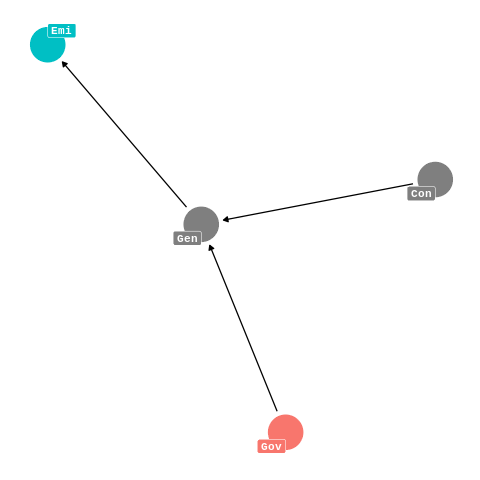

In [20]:
%%R
#Con is for Electricity Consumption
#Gen is for Electricity Generation
#Emi is for Carbon Emissions
#Gov is the ruling party

g <- dagitty('dag {
bb="-3.031,-2.369,3.222,3.541"
Con [pos="1.474,0.389"]
Emi [outcome,pos="-1.111,1.565"]
Gen [pos="-0.087,-0.002"]
Gov [exposure,pos="0.476,-1.816"]
Con -> Gen
Gen -> Emi
Gov -> Gen
}'
)
ggdag::ggdag_status(g, text = FALSE, use_labels = "name") +
  guides(color = "none") +  # Turn off legend
  theme_dag()

#### Prior Predictive

In [21]:
%%R 
#looking at the original data, we can create a prior predictive with synthetic data
prior1 <- c(
    prior(normal(0,10), class = Intercept),
    prior(normal(0,10), class = b, coef = generation_MM_MWh),
    prior(cauchy(0,10), class = sigma)
)

In [22]:
%%R
model1 <- brm(
    co2_emissions_mm_metric_tons ~ generation_MM_MWh,
    data = electricity_df,
    family = gaussian(),
    prior = prior1,
    warmup=2000, iter = 5000
)

R[write to console]: Compiling Stan program...

R[write to console]: Start sampling



R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



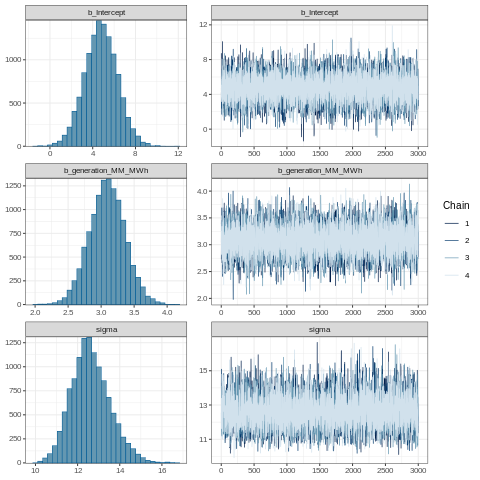

In [23]:
%%R
model1 %>% plot(
    combo = c("hist","trace"), widths = c(1,1.5),
    theme = theme_bw(base_size=10)
)